In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from einops import rearrange
from random import randint
from dataset import ImageDataset
from vit_trainer import VitTrainer

import matplotlib.pyplot as plt
import numpy as np

from utils import permute_image, topk_acc, greedy_refine_pred_perm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:
vit_trainer = VitTrainer.load_from_checkpoint('logs/w4sre0oq-100-e82.ckpt')
cfg = vit_trainer.cfg

vit = vit_trainer.model.to(device)
vit = vit.eval()
dataset = ImageDataset(cfg.data_dir, cfg.image_paths_pkl)

Selected index: 16559


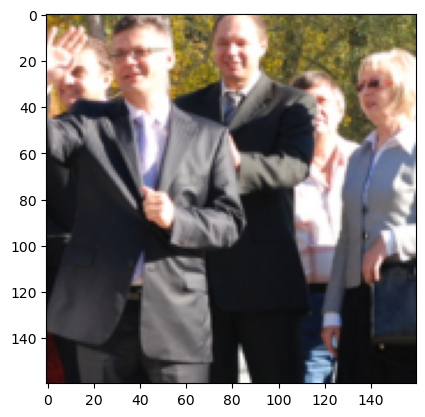

In [58]:
# idx = randint(0, len(dataset) - 1)
# idx = 50398
idx = 16559
print(f'Selected index: {idx}')
img = vit_trainer.resize_image(dataset[idx])

plt.imshow(img.permute(1, 2, 0))
plt.show()

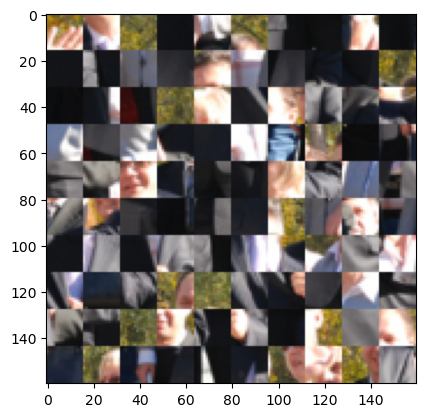

In [68]:
if True:
    gt_perm = None
    p_img, gt_perm = permute_image(img, patch_size=cfg.patch_size, perm=gt_perm)
    input_image = p_img
else:
    gt_perm = torch.arange(cfg.num_patches)
    input_image = img

plt.imshow(input_image.permute(1, 2, 0))
plt.show()

In [69]:
with torch.no_grad():
    x = input_image.unsqueeze(0).to(device)
    x = vit_trainer.image_transforms(x)
    y = vit(x)
pred_perm = y.squeeze().argmax(dim=-1)
pred_perm

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        93, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [70]:
gt = vit_trainer.gt_single[:, gt_perm].expand(y.size(0), -1)
# gt = vit_trainer.gt_single[:].expand(y.size(0), -1)
t1_acc = topk_acc(y, gt, k=1)
t5_acc = topk_acc(y, gt, k=5)
print(f'Top-1 accuracy: {t1_acc:.4f}')
print(f'Top-5 accuracy: {t5_acc:.4f}')

Top-1 accuracy: 0.0300
Top-5 accuracy: 0.0800


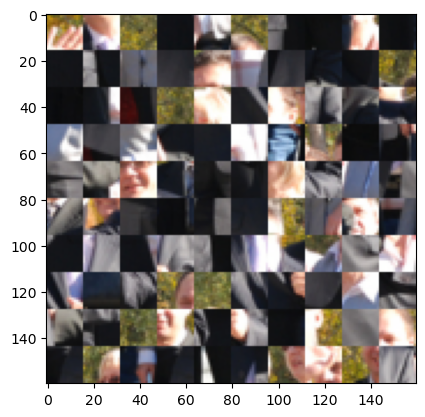

In [72]:
recon_image, _ = permute_image(input_image, cfg.patch_size, pred_perm)
plt.imshow(recon_image.permute(1, 2, 0))
plt.show()

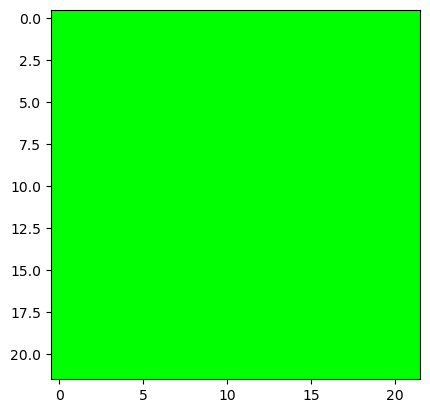

In [65]:
# Visualize the top-1 error locations
# If a patch position is predicted wrong, it will be colored red
# Otherwise, it will be colored green.


def visualize_top1_error(recon_image, pred_perm: torch.tensor, gt_perm: torch.tensor):
    gt_perm = gt_perm.squeeze()
    n_side = cfg.crop_image_to_px // cfg.patch_size
    errors = torch.where(pred_perm != gt_perm)[0]

    r = errors // n_side
    c = errors % n_side

    overlay = torch.zeros((n_side, n_side, 3), dtype=torch.float32)
    overlay[:] = torch.tensor([0, 1, 0], dtype=torch.float32)
    overlay[r, c] = torch.tensor([1, 0, 0], dtype=torch.float32)

    # Blend the overlay with the image
    # recon_image = recon_image.permute(1, 2, 0).cpu().numpy()

    plt.imshow(overlay)
    plt.show()


visualize_top1_error(recon_image, pred_perm, gt)

In [66]:
y_p = torch.nn.functional.softmax(y, dim=-1).squeeze()

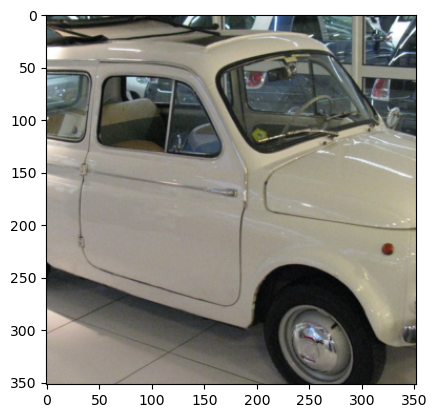

In [67]:
refined_pred_perm = greedy_refine_pred_perm(y_p)
refined_recon_image, _ = permute_image(img, cfg.patch_size, pred_perm)
plt.imshow(refined_recon_image.permute(1, 2, 0))
plt.show()

In [48]:
a = torch.rand(5)
a

tensor([0.6409, 0.4999, 0.4740, 0.1275, 0.5542])

In [49]:
a[[4, 3, 2, 1, 0]]

tensor([0.5542, 0.1275, 0.4740, 0.4999, 0.6409])

In [22]:
print(vit)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=768, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Transformer(
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (to_out): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=1024, out_features=2048, bias=True)
            (2): GELU(approximate='none')
  